# Aula 7 - Clusterização por Densidade

Na aula de hoje, vamos conversar um pouco sobre outro método de agrupamento que funciona um pouco diferente do KMeans. Vamos falar de:

- 1. DBSCAN
- 2. Aplicação para clusterização das estações de metrô
- 3. (Extra) Modelos de Mistura Gaussiana

## 1. DBSCAN

O DBSCAN é um algoritmo de clusterização baseado no conceito de **densidade**.

O nome do algoritmo é uma sigla, que explica bem seu funcionamento: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise.

O algoritmo foi proposto com o objetivo de proporcionar uma técnica de clusterização que possa funcionar **mesmo quando os clusters a serem criados não forem uniformes**, tendo **tamanho, forma e densidade variáveis**. 

Além disso, por construção o método funciona bem em contextos em que há **ruídos/outliers**, sendo capaz de detectá-los sem influenciar a criação dos clusters. 

Por fim, uma vantagem enorme é o fato do algoritmo **não demandar a determinação prévia da quantidade de clusters**, o que é uma vantagem interessante se não houver indicações do problema de negócio para esta determinação (embora, como veremos, ainda há hiperparâmetros importantes a serem determinados).

Vamos entender o funcionamento do algoritmo mais a fundo!

O DBSCAN tem como princípio fundamental a **determinação de regiões de alta densidade de observações**, que são **separadas entre si por regiões de baixa densidade**.

Lembrando que, por ser um algoritmo não-supervisionado de clusterização, quando nos referimos à "regiões" cuja densidade será aferida, estamos nos referindo a regiões **do espaço de features**.

Uma pergunta natural é: **como determinar a densidade de uma região?** Para responder esta pergunta, precisamos de algumas definições:

> **Densidade em um ponto $P$:** número de pontos dentro de um círculo de raio $\epsilon$ centrado no ponto $P$ (região chamada de vizinhança-$\epsilon$ de $P$);

> **Região densa**: dizemos que uma região é densa se o círculo de raio $\epsilon$ contém pelo menos um número mínimo de pontos (que chamaremos de $\text{minPts}$). Uma região densa **formará um cluster**.

Para visualizar as definições acima, considere a figura a seguir:

<img src=https://www.researchgate.net/publication/315326812/figure/fig2/AS:473095908663297@1489806262333/A-cluster-consists-of-core-points-red-and-border-points-green-Core-points-have-at.png width=500>

<img src=https://www.researchgate.net/publication/335485895/figure/fig2/AS:797412515909651@1567129367940/A-single-DBSCAN-cluster-with-Core-Border-and-Noise-Points.ppm width=500>

Dada a definição acima, podemos classificar pontos dentro de um cluster como:

> **Core points (pontos centrais)**: são pontos que estão no interior dos clusters (regiões densas). Matematicamente, um ponto é considerado core **se sua densidade é de pelo menos $\text{minPts}$**, ou seja, se **há pelo menos $\text{minPts}$ pontos dentro do círculo de raio $\epsilon$ centrado no ponto**.

> **Border points (pontos de fronteira)**: são pontos que estão na fronteira de um cluster. Matematicamente, estes pontos **têm densidade menor que $\text{minPts}$**, mas que **fazem parte da vizinhança-$\epsilon$ de um ponto central**.

> **Noisy points (pontos de ruído/outliers)**: são pontos que não são centrais nem de fronteira. Estes pontos não fazem parte do cluster, e são considerados outliers.


Olhando para as definições acima, e pras figuras, fica claro que $\epsilon$ e $\text{minPts}$ são os hiperparâmetros do modelo -- e que os clusters gerados são fortemente dependentes destes hiperparâmetros!


> - $\epsilon$ (`eps` no sklearn): determina o quão próximos (relativo a uma dada **métrica de distância**) os pontos devem estar próximos entre si para serem considerados vizinhos, e, eventualmente, parte de um cluster. Na prática, **se a distância entre dois pontos for menor ou igual a $\epsilon$, os pontos serão considerados vizinhos**;
<br><br>
>Se o valor de `eps` for muito pequeno, grande parte dos dados não serão clusterizados - muitos pontos serão considerados outliers, pois não haverá vizinhos suficientes para gerar uma região densa;<br><br>
>Por outro lado, se o valor de `eps` for muito grande, os clusters se fundirão, e a maioria dos pontos estarão em um único, grande cluster.<br><br>
>Portanto, a escolha de `eps` está muito relacionada com **a escala** das features, o que demanda cuidadosa análise exploratória.<br><br>
>Além disso, note que o  `eps` depende também fortemente da **métrica de distância** (`metric` no sklearn) a ser utilizada.


> - $\text{minPts}$ (`min_samples` no sklearn): o número mínimo de pontos que devem ser vizinhos para formar uma região densa, que será um cluster.
<br><br>
Valores maiores de `min_samples` são preferíveis para datasets com outliers, formando clusters mais significativos (isto é, um cluster só será formado se realmente tiver uma alta densidade).

Para algumas dicas práticas de como estimar bons valores para os hiper-parâmetros, [clique aqui](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation).

__________

Agora que entendemos os princípios e principais hiperparâmetros do DBSCAN, vamos agora entender os passos do algoritmo (que é bem simples!)

> **Passo 1**: o algoritmo escolhe aleatoriamente um dos pontos, e sua vizinhança-$\epsilon$ é calculada;

> **Passo 2**: se este ponto tem $\text{minPts}$ em sua vizinhança-$\epsilon$, a formação do cluster é iniciada (veja próximo passo). Se não, o ponto é marcado como outlier (mas pode ser considerado como border point de um outro cluster posteriormente). Se for um outlier, volte ao passo 1;

> **Passo 3**: se o ponto for um core point, todos os pontos na vizinhança são agregados ao cluster, e o passo 1 é aplicado a cada um deles;

> **Passo 4**: o processo do passo 3 é continuado até que todos os pontos tenham um cluster associado, ou seja marcado como noise.

Podemos visualizar a seguir o DBSCAN em funcionamento:


<img src="http://data-analysis-stats.jp/wp-content/uploads/2019/09/DBSCAN_01.gif" width=400>


<img src=https://i.pinimg.com/originals/bb/3d/5e/bb3d5e522cbcb2dd07a81f8118de2041.gif width=500>


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score

# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# criar o nosso toy dataset
x, y = make_blobs(n_samples = 500, 
                  n_features=2, 
                  centers = 4, 
                  cluster_std=1.2)

# criar o pipeline
cluster_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dbscan', DBSCAN())
])

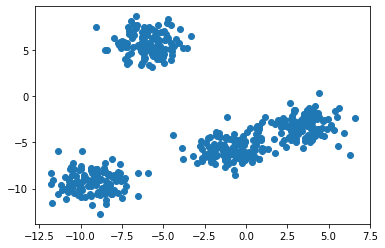

In [3]:
# transformar x em dataframe
x = pd.DataFrame(x, columns=['x1', 'x2'])

plt.scatter(x.x1, x.x2)

In [4]:
# ajustando o modelo
cluster_pipe.fit(x)

# atribuir os clusters
x['cluster'] = cluster_pipe['dbscan'].labels_

<AxesSubplot:xlabel='x1', ylabel='x2'>

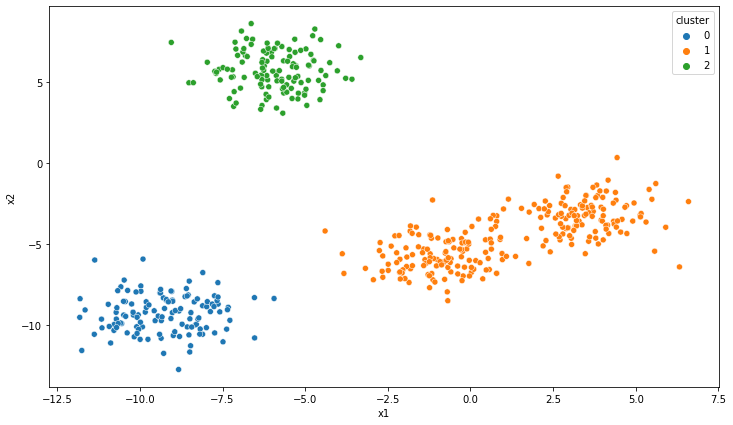

In [5]:
plt.figure(figsize=(12,7))
sns.scatterplot(x.x1, x.x2, hue = x.cluster, palette = 'tab10')

In [6]:
# função para avaliar a influência dos parâmetros
def plot_dbscan(eps, min_pts):

    x1 = x.copy()

    # criar o pipeline
    cluster_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=eps, min_samples=min_pts))
    ])

    x_cluster = x1.copy()

    # ajustar aos dados
    cluster_pipe.fit(x1)

    # criar a coluna de cluster em x
    x_cluster['cluster'] = cluster_pipe['dbscan'].labels_

    # construir gráfico
    print(f'DBSCAN - eps = {eps} - min_pts = {min_pts}')
    plt.figure(figsize=(12,7))
    sns.jointplot(x_cluster.x1, x_cluster.x2, hue = x_cluster.cluster, palette = 'tab10')
    plt.show()

    # análise da distribuição de pontos em cada cluster
    print('Distribuição de pontos')
    print(x_cluster.cluster.value_counts(normalize=True))

DBSCAN - eps = 0.1 - min_pts = 5


<Figure size 864x504 with 0 Axes>

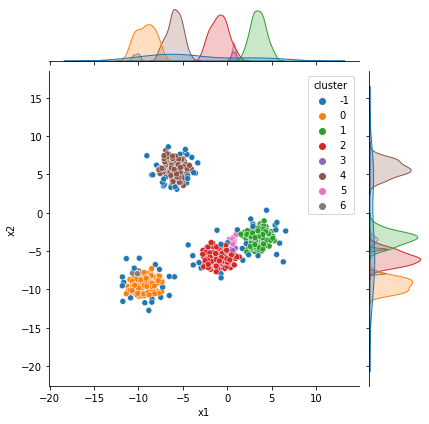

Distribuição de pontos
 2    0.216
 0    0.200
 1    0.200
 4    0.200
-1    0.146
 5    0.016
 6    0.012
 3    0.010
Name: cluster, dtype: float64
DBSCAN - eps = 0.2 - min_pts = 5


<Figure size 864x504 with 0 Axes>

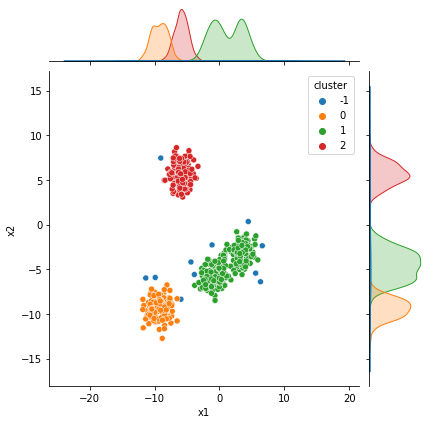

Distribuição de pontos
 1    0.486
 2    0.248
 0    0.244
-1    0.022
Name: cluster, dtype: float64
DBSCAN - eps = 0.30000000000000004 - min_pts = 5


<Figure size 864x504 with 0 Axes>

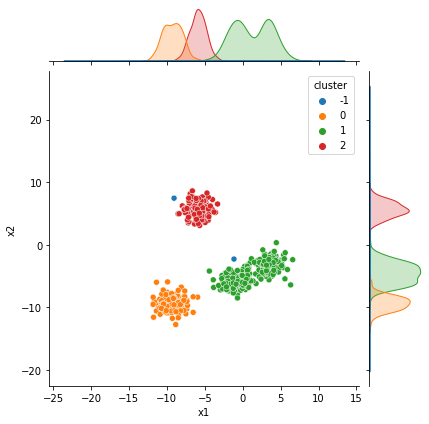

Distribuição de pontos
 1    0.498
 0    0.250
 2    0.248
-1    0.004
Name: cluster, dtype: float64
DBSCAN - eps = 0.4 - min_pts = 5


<Figure size 864x504 with 0 Axes>

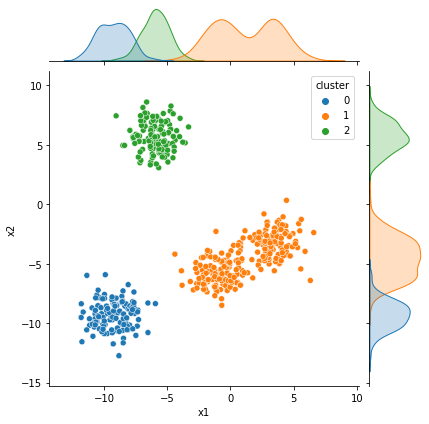

Distribuição de pontos
1    0.50
0    0.25
2    0.25
Name: cluster, dtype: float64
DBSCAN - eps = 0.5 - min_pts = 5


<Figure size 864x504 with 0 Axes>

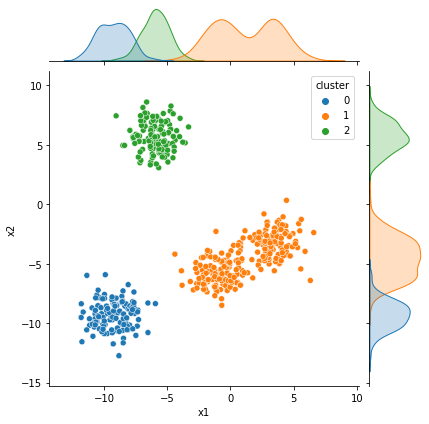

Distribuição de pontos
1    0.50
0    0.25
2    0.25
Name: cluster, dtype: float64
DBSCAN - eps = 0.6 - min_pts = 5


<Figure size 864x504 with 0 Axes>

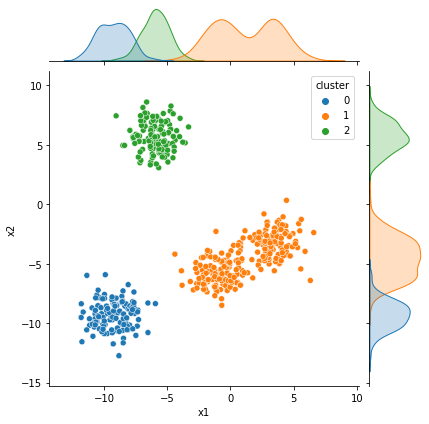

Distribuição de pontos
1    0.50
0    0.25
2    0.25
Name: cluster, dtype: float64
DBSCAN - eps = 0.7000000000000001 - min_pts = 5


<Figure size 864x504 with 0 Axes>

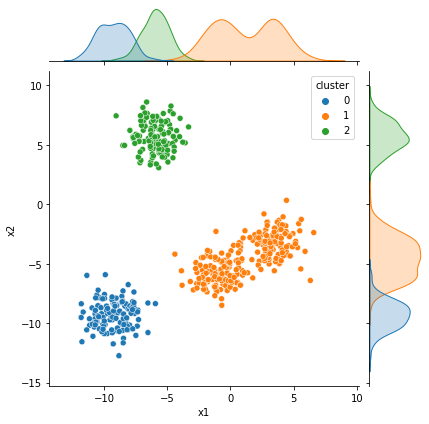

Distribuição de pontos
1    0.50
0    0.25
2    0.25
Name: cluster, dtype: float64
DBSCAN - eps = 0.8 - min_pts = 5


<Figure size 864x504 with 0 Axes>

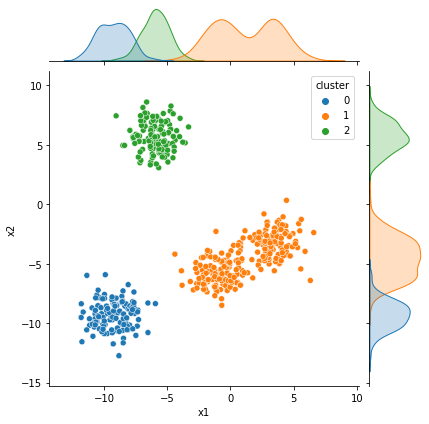

Distribuição de pontos
1    0.50
0    0.25
2    0.25
Name: cluster, dtype: float64
DBSCAN - eps = 0.9 - min_pts = 5


<Figure size 864x504 with 0 Axes>

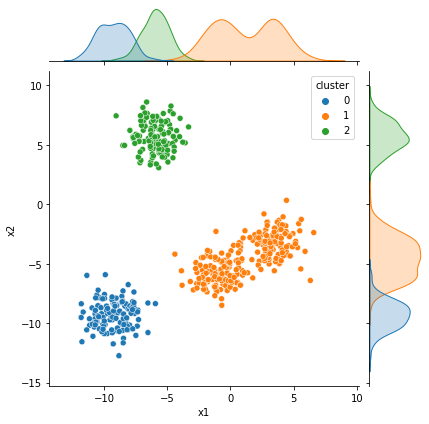

Distribuição de pontos
1    0.50
0    0.25
2    0.25
Name: cluster, dtype: float64
DBSCAN - eps = 1.0 - min_pts = 5


<Figure size 864x504 with 0 Axes>

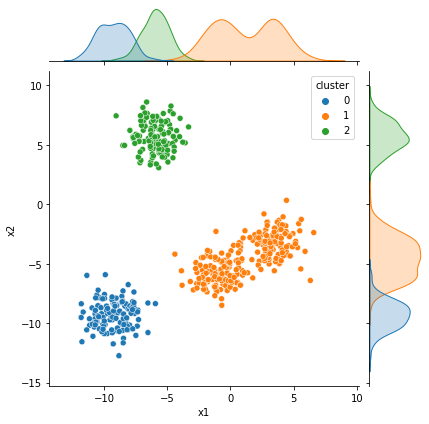

Distribuição de pontos
1    0.50
0    0.25
2    0.25
Name: cluster, dtype: float64


In [7]:
# avaliando influência do eps
eps_list = np.arange(0.1, 1.1, 0.1)

for eps in eps_list:
    plot_dbscan(eps, 5)

DBSCAN - eps = 100 - min_pts = 5


<Figure size 864x504 with 0 Axes>

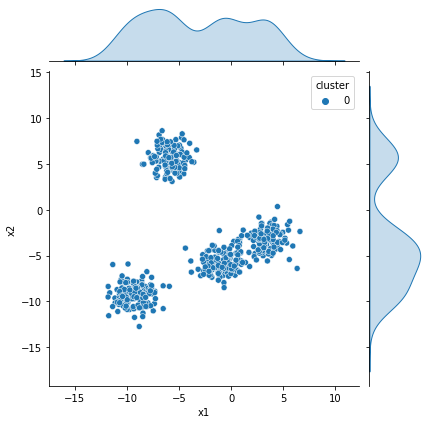

Distribuição de pontos
0    1.0
Name: cluster, dtype: float64


In [8]:
plot_dbscan(eps=100, min_pts=5)

DBSCAN - eps = 0.3 - min_pts = 1


<Figure size 864x504 with 0 Axes>

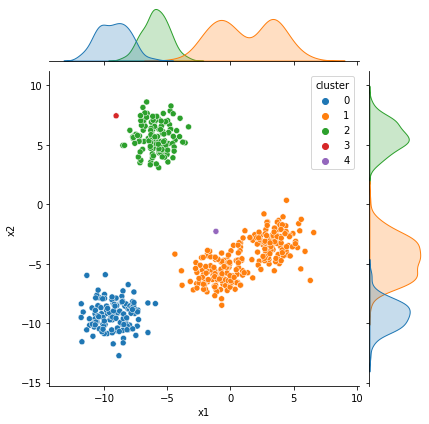

Distribuição de pontos
1    0.498
0    0.250
2    0.248
3    0.002
4    0.002
Name: cluster, dtype: float64
DBSCAN - eps = 0.3 - min_pts = 5


<Figure size 864x504 with 0 Axes>

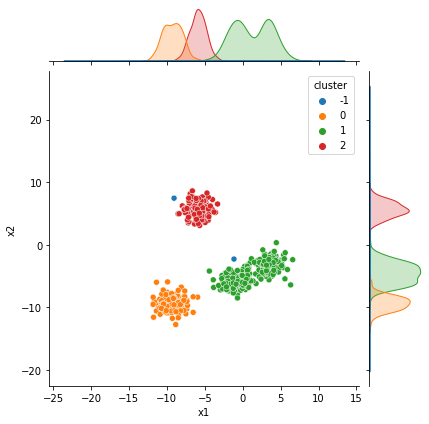

Distribuição de pontos
 1    0.498
 0    0.250
 2    0.248
-1    0.004
Name: cluster, dtype: float64
DBSCAN - eps = 0.3 - min_pts = 10


<Figure size 864x504 with 0 Axes>

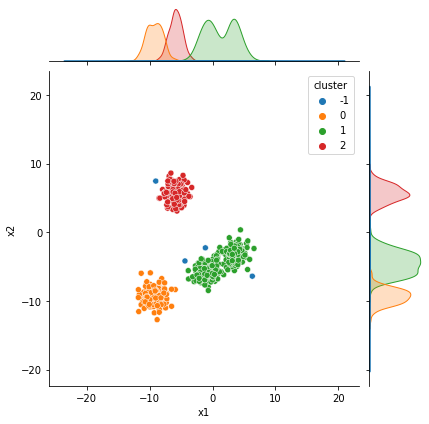

Distribuição de pontos
 1    0.494
 0    0.250
 2    0.248
-1    0.008
Name: cluster, dtype: float64
DBSCAN - eps = 0.3 - min_pts = 50


<Figure size 864x504 with 0 Axes>

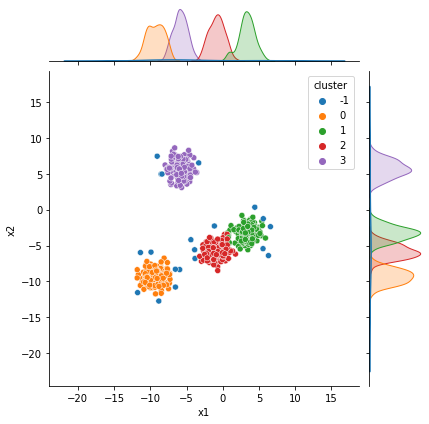

Distribuição de pontos
 2    0.244
 3    0.242
 1    0.238
 0    0.236
-1    0.040
Name: cluster, dtype: float64


In [9]:
# avaliando influência do eps
min_pt_list = [1, 5, 10, 50]

for n in min_pt_list:
    plot_dbscan(0.3, n)

## 2. Clusterização das Estações de Metrô de SP

**Objetivo**: tentar reproduzir a separação das linhas do metrô de SP usando o DBSCAN.

In [10]:
# ler os dados
data = pd.read_csv('metroetrem_sp_comlinks.csv')
data.head()

,num_lin,nome_lin,long,lat,estacao_upp,link
0,4,AMARELA,-46723768,-23586440,SAO PAULO MORUMBI,BUTANTA
1,4,AMARELA,-46708157,-23571857,BUTANTA,PINHEIROS
2,4,AMARELA,-46701610,-23567392,PINHEIROS,FARIA LIMA
3,4,AMARELA,-46694102,-23567269,FARIA LIMA,FRADIQUE COUTINHO
4,4,AMARELA,-46684259,-23566228,FRADIQUE COUTINHO,OSCAR FREIRE


In [11]:
# tipos de variáveis
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 17
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   num_lin      196 non-null    int64 
 1   nome_lin     196 non-null    object
 2   long         196 non-null    int64 
 3   lat          196 non-null    int64 
 4   estacao_upp  196 non-null    object
 5   link         196 non-null    object
dtypes: int64(3), object(3)
memory usage: 10.7+ KB


In [12]:
# analisando distribuições de estações por linha
data.nome_lin.value_counts(normalize=True)

AZUL         0.117347
DIAMANTE     0.112245
RUBI         0.096939
VERMELHA     0.091837
ESMERALDA    0.091837
LILAS        0.086735
CORAL        0.081633
VERDE        0.071429
SAFIRA       0.066327
TURQUESA     0.066327
AMARELA      0.051020
PRATA        0.051020
JADE         0.015306
Name: nome_lin, dtype: float64

In [13]:
# criando uma paleta de cores personalizada
colors = {
    'AMARELA': '#f0d20e',
    'AZUL': '#0515a3',
    'CORAL': '#e07000',
    'DIAMANTE': '#919190',
    'ESMERALDA': '#0bd6a3',
    'JADE': '#0bd637',
    'LILAS': '#a659de',
    'PRATA': '#616161',
    'RUBI': '#9c2438',
    'SAFIRA': '#0c0880',
    'TURQUESA': '#267587',
    'VERDE': '#048a37',
    'VERMELHA': '#d10202'
}

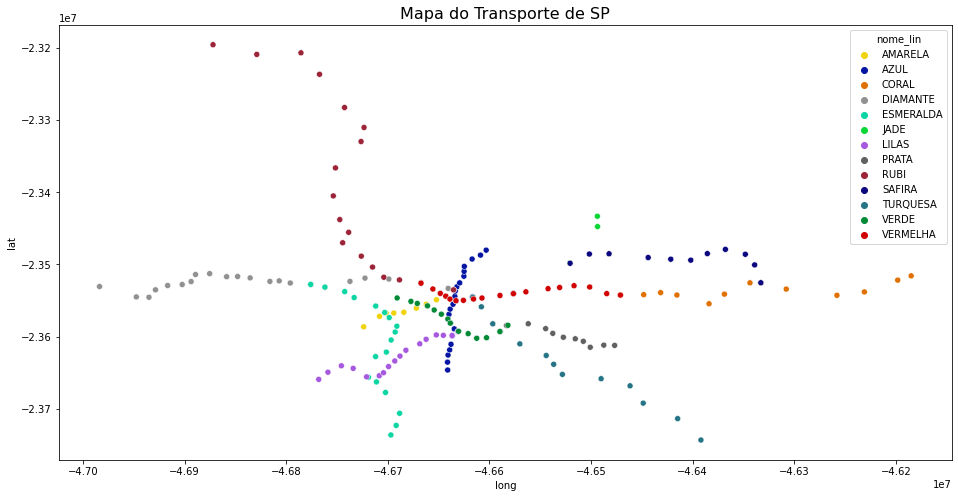

In [14]:
# criando a figura do transporte de SP
plt.figure(figsize=(16,8))
plt.title('Mapa do Transporte de SP', size = 16)
sns.scatterplot(data.long, data.lat, hue = data.nome_lin, palette=colors)
plt.show()

In [15]:
# criando nosso pipeline de modelagem
def plot_dbscan2(x, eps, min_pts):

    x1 = x.copy()

    # criar o pipeline
    cluster_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=eps, min_samples=min_pts))
    ])

    x_cluster = x1.copy()

    # ajustar aos dados
    cluster_pipe.fit(x1)

    # criar a coluna de cluster em x
    x_cluster['cluster'] = cluster_pipe['dbscan'].labels_

    # construir gráfico
    print(f'DBSCAN - eps = {eps} - min_pts = {min_pts}')
    plt.figure(figsize=(12,7))
    sns.jointplot(x_cluster.long, x_cluster.lat, hue = x_cluster.cluster, palette = 'tab10')
    plt.show()

    # análise da distribuição de pontos em cada cluster
    print('Distribuição de pontos')
    print(x_cluster.cluster.value_counts(normalize=True))

DBSCAN - eps = 0.3 - min_pts = 3


<Figure size 864x504 with 0 Axes>

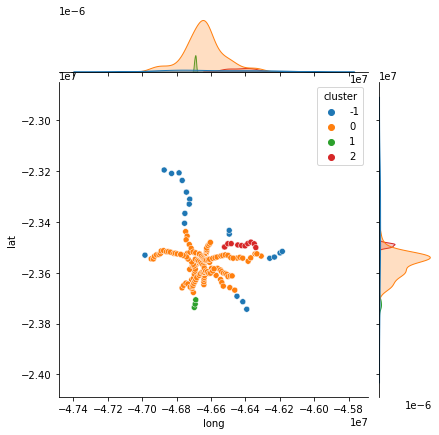

Distribuição de pontos
 0    0.831633
-1    0.096939
 2    0.056122
 1    0.015306
Name: cluster, dtype: float64


In [16]:
plot_dbscan2(data[['long', 'lat']], eps = 0.3, min_pts=3)

_____

**Exercício 1**

Aplique a clusterização DBSCAN no conjunto de dados `german-credit-data.csv`, segundo as instruções:

- não precisa separar conjunto de treino e teste
- construa um objeto processador para resolver problemas de dados faltantes e tratar variáveis categóricas.
- utilize a mesma metodologia apresentada para selecionar os hiperparâmetros do DBSCAN
- analise as estatísticas descritivas de cada cluster com o método `groupby`
- se houver, analise os *outliers*

___

**Exercício 2**

Aplique a clusterização DBSCAN no conjunto de dados `german-credit-data.csv`, segundo as instruções:

- não precisa separar conjunto de treino e teste
- construa um objeto processador para resolver problemas de dados faltantes e tratar variáveis categóricas.
- utilize o objeto `StratifiedKFold` com 10 splits e o objeto `RandomizedSearchCV` com a métrica  `v_measure_score`
- analise as estatísticas descritivas de cada cluster com o método `groupby`
- se houver, analise os *outliers*
___

## Exercício 1

In [17]:
df = pd.read_csv('german_credit_data.csv')

df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [18]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [19]:
x = df.drop(['Risk'], axis = 1)
x.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [20]:
num_features = x.select_dtypes(include=np.number).columns.tolist()
cat_features = x.select_dtypes(exclude=np.number).columns.tolist()

pipe_num = Pipeline([('input_na_num', SimpleImputer(strategy='mean'))])
pipe_cat = Pipeline([
    ('input_na_cat', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ordinal_cod', OrdinalEncoder())
])

pre_processador = ColumnTransformer([
    ('transf_num', pipe_num, num_features),
    ('tranf_cat', pipe_cat, cat_features)
])

In [21]:
def eval_dbscan(x,eps,min_pts):

    x1 = x.copy()
    
    transf_pipe = Pipeline([
        ('preprocess', pre_processador),
        ('scaler', StandardScaler())
    ])
    x2 = transf_pipe.fit_transform(x1)
    
    dbscan_pipe = Pipeline([
        ('preprocess', pre_processador),
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=eps,min_samples=min_pts))
    ])
    
    dbscan_pipe.fit(x1)
    
    return silhouette_score(x2, labels=dbscan_pipe['dbscan'].labels_)

In [ ]:
eps_list = np.arange(0.5, 3.9,0.1)
min_pt_list = np.arange(1,6,1)
results = pf.DataFrame(columns=['eps', 'min_pts', 's_score'])

i = 0
for eps in eps_list:
    for min_pt 

# 3. Modelos de Mistura Gaussiana (*Soft Clustering*)

Os modelos de mistura Gaussiana são modelos de clusterização probabílistica que pode ser utilizado para agrupar dados não rotulados, de forma bem semelhante ao algoritmo KMeans. No entanto, os modelos de mistura Gaussiana apresentam algumas vantagens sobre o KMeans:

- o algoritmo KMeans não leva em consideração a variância dos subgrupos - que no caso de duas dimensões seria a largura da curva Gaussiana

<img src="https://th.bing.com/th/id/R.fa4d074ace95f3ec77c15b3e0f30ae9a?rik=ahsAJAJ83G%2fMhg&riu=http%3a%2f%2fwww.juzicode.com%2fwp-content%2fuploads%2f2021%2f07%2fimage-28.png&ehk=2iwVXmgsJJ3QKJzwlpba2wwPpv40Bdz2TETd%2b%2bLF2Ec%3d&risl=&pid=ImgRaw&r=0">

- KMeans coloca um "círculo" (ou uma "hiper-esfera") no centro de cada cluster, com o raio definido pela posição do ponto mais distante do centro.

<img src="https://miro.medium.com/max/552/1*Zl8_vxkkqv-ZV3IWZdRCmw.png">

- pode até funcionar para clusters bem separados e definidos, mas pode ser um problema no caso de clusters próximos

<img src="https://1.bp.blogspot.com/-R_yo0MMeaB0/XplYdzIkjYI/AAAAAAAAERg/Y1BDLHtUtuYBglFHVOB2vPG5EAims1O6wCNcBGAsYHQ/s1600/gaussian_cluster.png">

- em constraste, os modelos Gaussianos conseguem lidar bem com cluster próximos e "não-esféricos"

<img src="https://miro.medium.com/max/552/1*ytZYLtTTkhHbtOhe63jstA.png">

- Enquanto o KMeans realiza uma "hard-clustering", o GMM pode ser encara como uma "soft-clustering", ou seja, no KMeans é deterministicamente alocado em cada cluster (e apenas um cluster) enquanto no GMM, o ponto pode pertencer a mais de um cluster *ao mesmo tempo*, visto que o ponto possui *probabilidades de pertencimento* a cada cluster

Na biblioteca `scikit-learn`, a classe utilizada é o [GMM](https://scikit-learn.org/0.16/modules/generated/sklearn.mixture.GMM.html).

- o método para atribuir o cluster é o `predict`
- para verificar as probabilidades de pertencimento de cada cluster usamos o `predict_proba`

O principal hiperparâmetro a ser modificado é o `n_components`, que controla a quantidade de "gaussianas" que o algoritmo vai buscar nos dados.

## Modo de funcionamento

Como o nome explica, o modelo de mistura Gaussiana supõe que a distribuição dos dados é uma "soma" (superposição) de várias distribuições Gaussianas. Ao invés de identificar os clusters pela proximidade aos centróides, nós buscamos ajustar $k$ distribuições Gaussianas aos dados. 

Essas distribuições gaussianas são geradas estimando os parâmetros das distribuições como a média e a variância para cada cluster, e também pode ser ponderado por pesos de cada cluster. Depois desse aprendizado dos parâmetros, podemos calcular a probabilidade de pertencimento de cada cluster.

<img src="https://miro.medium.com/max/1200/1*lTv7e4Cdlp738X_WFZyZHA.png">

Todas as distribuições são multiplicadas por um peso normalizador $\pi$ ($\pi_1 + \pi_2 + \pi_3=1$) para levar em consideração o fato de que existem diferentes números de amostras para cada cluster.

Não vamos entrar nos aspectos técnicos do cálculo, mas os curiosos podem procurar [nesse link](https://www.kaggle.com/code/vipulgandhi/gaussian-mixture-models-clustering-explained/notebook) e [nesse link](https://brilliant.org/wiki/gaussian-mixture-model/). 

______

**Exercício 3 (DESAFIO)**

Usando agora o algoritmo de Modelos de Mistura Gaussiana e o dataset `garments_worker_productivity.csv`, realize a clusterização das features para aprender sobre a estrutura dos dados

- use o Pipeline para processamento
- elimine a coluna `actual_productivity` (Target)
- utilize o método da silhueta para descobrir o número adequado de clusters

_____